In [133]:
cd /home/novella/PycharmProjects/stock-price-trend-prediction-remote-magi

/home/novella/PycharmProjects/stock-price-trend-prediction-remote-magi


In [134]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from enum import Enum
from sklearn.cluster import MeanShift, KMeans
import numpy as np
import pickle

import src.utils.lob_util as lbu
import src.config as co

np.random.seed(0)
plt.rcParams["figure.figsize"] = (16,9)

print(os.getcwd())

/home/novella/PycharmProjects/stock-price-trend-prediction-remote-magi


In [135]:
PATH_NAME = "data/LOBSTER_6/unzipped/"
STOCKS_FNAME = ["_data_dwn_48_332__{}_2021-07-01_2021-08-06_10", "_data_dwn_48_332__{}_2020-03-01_2020-04-03_10"]
STOCKS_PAIRS = [("AAPL", "NVDA"), ("ZM", "AAWW"), ("AGNC", "LYFT")]
STOCKS = ["AAPL", "TSLA", "ZM", "AAWW", "AGNC", "LYFT"]

class Period(Enum):
    JULY = 0
    MARCH = 1

class Granularity(Enum):
    SEC = 1
    MIN = 60
    TEN_MIN = int(60*10)
    HALF_HOUR = int(60*30)
    HOUR = 60*60
    DAY = int(60*60*6.5)
    TWO_DAYS = int(60*60*6.5*2)
    THREE_DAYS = int(60*60*6.5*3)
    FIVE_DAYS = int(60*60*6.5*5)

In [136]:
MID_PRICES = {Period.JULY:None, Period.MARCH:None}

for scen in Period:
    daily_midprice = pd.DataFrame()
    RETURNS_FNAME = "data/LOBSTER_6/price_return_df_5_scen{}.dat".format(scen.value)

    if not os.path.exists(RETURNS_FNAME):

        for i, i_stock in enumerate(STOCKS):
            print("Processing stock", i, i_stock)

            stock_path = PATH_NAME + STOCKS_FNAME[scen.value].format(i_stock)
                
            tra_days = os.listdir(stock_path)
            tra_days.sort()

            out_df = lbu.from_folder_to_unique_df(
                stock_path,
                level=10,
                granularity=co.Granularity.Sec1,
                boundaries_purge=0
            )
            out_df = out_df.fillna(method="ffill")
            daily_midprice[i_stock] = (out_df.loc[:, "psell1"] + out_df.loc[:, "pbuy1"]) / (2 * 10000)
            
            print("HAS CORRECT SHAPE?", out_df.shape[0], out_df.shape[0] == 60*60*6.5*25)
            out_df = None
        
        MID_PRICES[scen] = daily_midprice
        
        with open(RETURNS_FNAME, "wb") as f:
             pickle.dump(daily_midprice, f)
    else:
        print("Loading pickle...")
        with open(RETURNS_FNAME, "rb") as f:
            daily_midprice = pickle.load(f)
        
        MID_PRICES[scen] = daily_midprice

Loading pickle...
Loading pickle...


In [137]:
# daily_midprice = mids[0]  # 0 is JULY
# print(daily_midprice.shape[0])
# print(60*60*6.5*25)
# print("60*60*6.5*25, where 6.5 is the hours in a trading day, 25 days")
# daily_midprice

In [138]:
def get_trading_day(df, day, gran=Granularity.HOUR):
    return df[gran.value*day:gran.value*(day+1)]

get_trading_day(MID_PRICES[Period.JULY], day=0)

,AAPL,TSLA,ZM,AAWW,AGNC,LYFT
date,,,,,,
2021-07-01 09:30:00,136.580,684.025,386.830,68.840,16.930,61.235
2021-07-01 09:30:01,136.580,683.730,386.590,68.775,16.935,61.470
2021-07-01 09:30:02,136.670,683.595,386.595,68.775,16.935,61.300
2021-07-01 09:30:03,136.685,682.505,386.555,68.775,16.935,61.370
2021-07-01 09:30:04,136.715,682.625,386.555,68.775,16.935,61.360
...,...,...,...,...,...,...
2021-07-01 10:29:55,136.555,680.170,387.400,67.930,16.955,62.710
2021-07-01 10:29:56,136.555,680.340,387.400,67.930,16.955,62.715
2021-07-01 10:29:57,136.555,680.255,387.400,67.930,16.955,62.715


In [149]:
def eval_returns(daily_midprice, gran=Granularity.HOUR):
    norm = eval_norm_mid(daily_midprice, gran=Granularity.HOUR.SEC).iloc[::gran.value, :]
    rets = (norm - norm.shift(-1)) / norm.shift(-1)
    rets = rets.dropna()
    return rets

def eval_norm_mid(daily_midprice, gran=1):
    midprice_ret = daily_midprice.iloc[::gran.value, :]
    midprice_ret = midprice_ret / midprice_ret.iloc[0, :]
    return midprice_ret

In [150]:
def increment_volatiltuy(df_jul, df_mar, gran=Granularity.HOUR):
    period_stats = pd.DataFrame()
    ret_jul = eval_returns(df_jul, gran)
    ret_mar = eval_returns(df_mar, gran)

    period_stats["vol_jul"] = ret_jul.describe().loc['std']
    period_stats["vol_mar"] = ret_mar.describe().loc['std']

    period_stats["perc_vol_%"] = ((period_stats["vol_mar"] - period_stats["vol_jul"]) / period_stats["vol_jul"])*100  # how much more volatile was MARCH wrt to JULY
    stats = period_stats.describe()

    me = round(stats.loc['mean', 'perc_vol_%'])
    st = round(stats.loc['std', 'perc_vol_%'])
    print("covid period is {}+/-{}% more volatile ({}) than the july 2021 period.".format(me, st, gran))

increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.HOUR)
increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.MIN)
increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.DAY)
increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.TWO_DAYS)
increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.THREE_DAYS)
increment_volatiltuy(MID_PRICES[Period.JULY], MID_PRICES[Period.MARCH], gran=Granularity.FIVE_DAYS)

covid period is 316+/-209% more volatile (Granularity.HOUR) than the july 2021 period.
covid period is 832+/-521% more volatile (Granularity.MIN) than the july 2021 period.
covid period is 297+/-139% more volatile (Granularity.DAY) than the july 2021 period.
covid period is 301+/-192% more volatile (Granularity.TWO_DAYS) than the july 2021 period.
covid period is 346+/-239% more volatile (Granularity.THREE_DAYS) than the july 2021 period.
covid period is 816+/-710% more volatile (Granularity.FIVE_DAYS) than the july 2021 period.


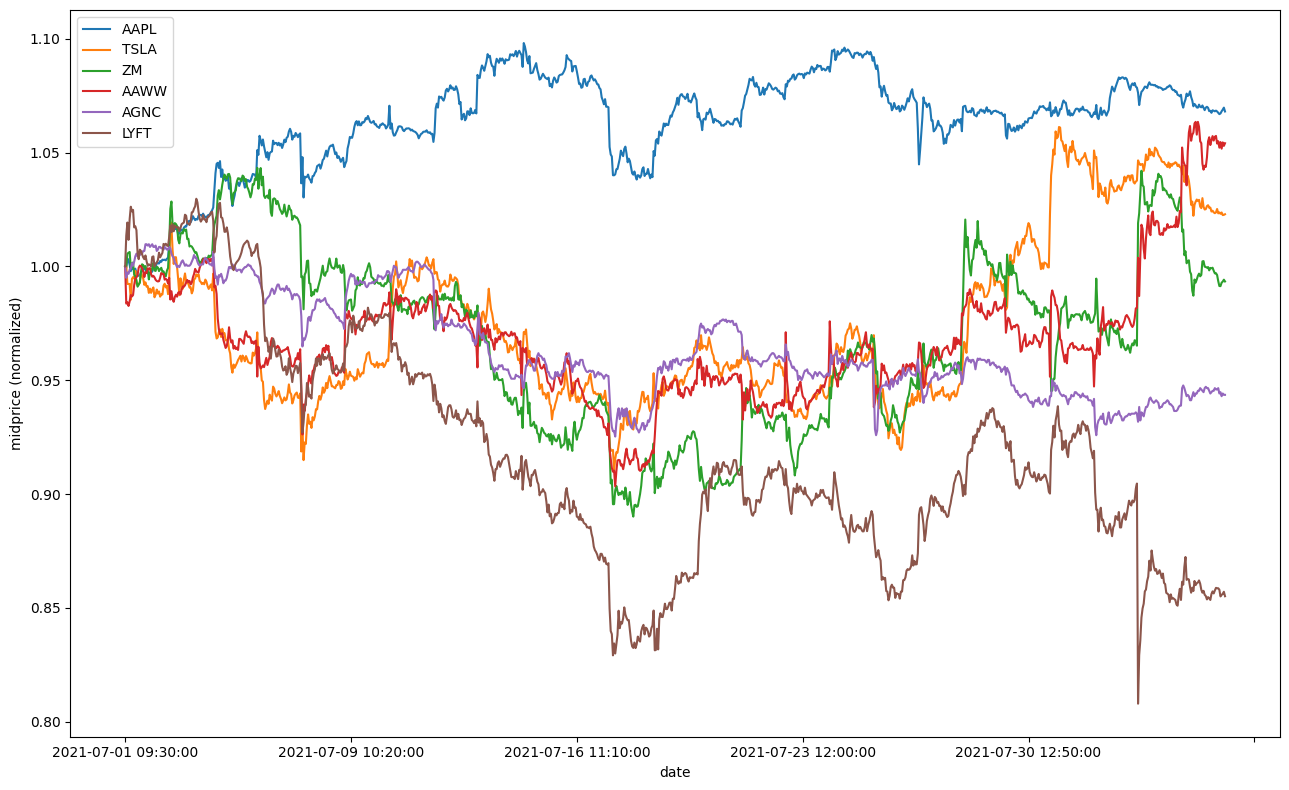

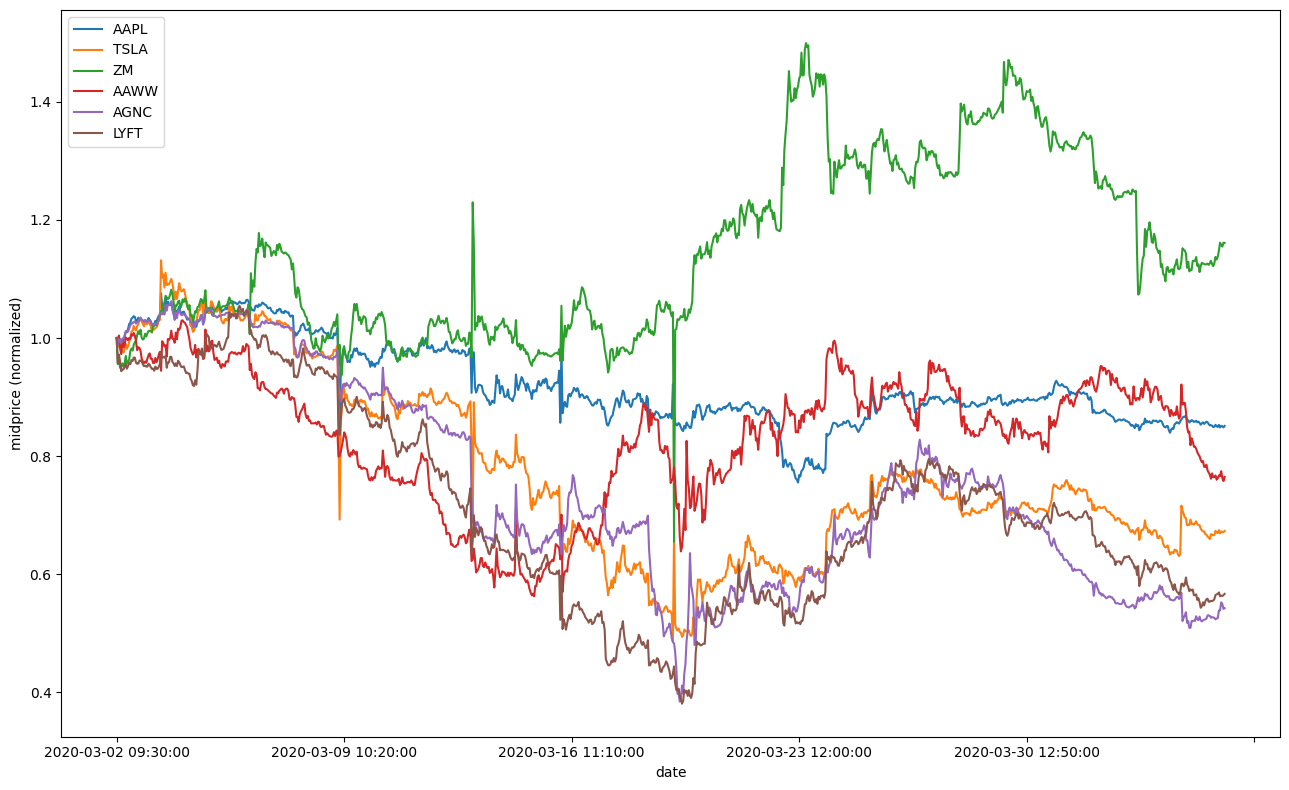

In [151]:
def plot_mids(mids_df):
    mids_df.index = [str(ind) for ind in mids_df.index]
    x_axis = list(mids_df.index)
    fig, ax = plt.subplots(figsize=(13, 8))

    ax = mids_df.plot(ax = ax)

    # SCEWNARIO = ('2021-07-22', '2021-07-29', '2021-08-06')
    # SCEWNARIO = ('2020-03-20', '2020-03-27', '2020-04-03')
    # yli = ax.get_ylim()
    # ax.vlines(x=x_axis.index(SCEWNARIO[0])+13, ymin=yli[0], ymax=yli[1], color='black') # 13 mezz'ore in 6.5 ore
    # ax.vlines(x=x_axis.index(SCEWNARIO[1])+13, ymin=yli[0], ymax=yli[1], color='black')
    # ax.vlines(x=x_axis.index(SCEWNARIO[2])+13, ymin=yli[0], ymax=yli[1], color='black')
    # plt.xticks(rotation=10)

    plt.ylabel("midprice (normalized)")
    plt.xlabel("date")
    # plt.ylim([.4, 1.5])
    ax.legend(loc='upper left')
    plt.tight_layout()
    # fig.savefig('scenario-mar.pdf', dpi=400)

plot_mids(eval_norm_mid(MID_PRICES[Period.JULY], gran=Granularity.TEN_MIN))
plot_mids(eval_norm_mid(MID_PRICES[Period.MARCH], gran=Granularity.TEN_MIN))

In [297]:
from collections import Counter

class Label(Enum):
    UP = 2.
    STABLE = 1.
    DOWN = 0.

def counter_labels(data):
    counter = Counter(data)
    tot = sum(counter.values())
    pers = []
    for k in Label:
        val = counter[k.value]
        per = round(100*val/tot, 2)
        pers.append(per)
        # print("> label {} has {} ({}%) classes".format(k.name, val, per))
    return pers

def similarity_score(vals):
    a, b, c = vals[0], vals[1], vals[2]
    abs_diffs = [abs(a - b), abs(a - c), abs(b - c)]
    return sum(abs_diffs) / 3

In [304]:
def dataset_distr(window_size_backward, window_size_forward, stock, period, scaler):
    exp = pd.DataFrame()
    exp["mid"] = MID_PRICES[period].loc[:,[stock]]
    exp["mid+t"] = exp["mid"].rolling(window_size_forward ).mean().shift(-window_size_forward+1)
    exp["mid-t"] = exp["mid"].rolling(window_size_backward).mean()
    exp = exp[(window_size_backward - 1):-(window_size_forward - 1)]

    exp["change"] = (exp["mid+t"] - exp["mid-t"].shift(-1)) / exp["mid-t"].shift(-1)
    ratio_mu, ratio_si = exp["change"].mean(), exp["change"].std()

    th_u = ratio_mu+ratio_si*scaler
    th_d = ratio_mu-ratio_si*scaler

    # >>>> PLOTTING <<<<<
    # exp.index = [str(ind) for ind in exp.index]
    # exp["change"].plot()
    # plt.axhline(y=ratio_mu, color="red")
    # plt.axhline(y=th_u,     color="green")
    # plt.axhline(y=th_d,     color="green")
    # plt.show()

    exp["pred"] = np.ones (exp.shape[0])
    exp["pred"] = np.where(exp["change"] > th_u, 2, exp["pred"])
    exp["pred"] = np.where(exp["change"] < th_d, 0, exp["pred"])

    # labels 0 (down), 1 (stable), 2 (down)
    return counter_labels(exp["pred"])

In [314]:
fww = bww = [10, 20, 30, 50, 100]
DISTR = np.ones((len(bww), len(fww)))

for iib, b in enumerate(bww):
    for iif, f in enumerate(fww):
        print("done", b, f)
        DISTR[iib, iif] = similarity_score(dataset_distr(b, f, "ZM", Period.MARCH, scaler=.5))

done 10 10
done 10 20
done 10 30
done 10 50
done 10 100
done 20 10
done 20 20
done 20 30
done 20 50
done 20 100
done 30 10
done 30 20
done 30 30
done 30 50
done 30 100
done 50 10
done 50 20
done 50 30
done 50 50
done 50 100
done 100 10
done 100 20
done 100 30
done 100 50
done 100 100


In [315]:
DISTR

array([[66.40666667, 66.37333333, 66.34666667, 66.29333333, 66.14      ],
       [66.35333333, 66.32666667, 66.3       , 66.26      , 66.09333333],
       [66.3       , 66.29333333, 66.27333333, 66.23333333, 66.06      ],
       [66.23333333, 66.22666667, 66.21333333, 66.16      , 66.00666667],
       [66.09333333, 66.07333333, 66.04666667, 65.99333333, 65.84      ]])

In [303]:
similarity_score([33,33,33])

0.0